In [1]:
import pandas as pd 
df = pd.read_csv("/kaggle/input/spl-preprocessed-reviews/spl_preprocessed_reviews_14_may_2025.csv")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Keep only labeled data
labeled_df = df[df['sentiment'].notna()].copy()

# Create stratification column
labeled_df['stratify_col'] = labeled_df['lang_type'].astype(str) + "_" + labeled_df['sentiment'].astype(str)

# Stratified split
train_df, test_df = train_test_split(
    labeled_df,
    test_size=0.2,
    stratify=labeled_df['stratify_col'],
    random_state=42
)

In [4]:
train_df.head()

,review_text,sentiment,review_time,rating,app_name,cleaned_review,tokens,filtered_tokens,lemmatized,lang_type,stratify_col
4126,This apps UI not looks good to me. As an UI/UX...,Negative,2025-01-17 5:01:13,1,BRAC Bank Astha,this apps ui not looks good to me as an uiux d...,"['this', 'apps', 'ui', 'not', 'looks', 'good',...","['apps', 'ui', 'not', 'looks', 'good', 'uiux',...","['apps', 'ui', 'not', 'look', 'good', 'uiux', ...",english,english_Negative
77152,The UI is ao backdated and confusing. Doesn't ...,Negative,2023-08-01 13:58:03,2,AB Direct Internet Banking,the ui is ao backdated and confusing doesnt se...,"['the', 'ui', 'is', 'ao', 'backdated', 'and', ...","['ui', 'ao', 'backdated', 'confusing', 'doesnt...","['ui', 'ao', 'backdated', 'confusing', 'doesnt...",english,english_Negative
4057,Very nice banking app but it's work too slow .,Negative,2025-02-21 10:02:44,4,BRAC Bank Astha,very nice banking app but its work too slow,"['very', 'nice', 'banking', 'app', 'but', 'its...","['nice', 'banking', 'app', 'work', 'slow']","['nice', 'banking', 'app', 'work', 'slow']",english,english_Negative
4075,K There should be two verification options for...,Negative,2025-02-17 11:21:25,2,BRAC Bank Astha,k there should be two verification options for...,"['k', 'there', 'should', 'be', 'two', 'verific...","['k', 'two', 'verification', 'options', 'money...","['k', 'two', 'verification', 'option', 'money'...",english,english_Negative
77080,সবসময় যদি আন্ডার মেইনটেনেন্স থাকে তাইলে অ্যাপ...,Negative,2024-02-16 6:50:05,1,AB Direct Internet Banking,সবসময় যদি আন্ডার মেইনটেনেন্স থাকে তাইলে অ্যাপ...,"['সবসময়', 'যদি', 'আন্ডার', 'মেইনটেনেন্স', 'থা...","['সবসময়', 'আন্ডার', 'মেইনটেনেন্স', 'থাকে', 'ত...","['সবসময়', 'আন্ডার', 'মেইনটেনেন্স', 'থাকে', 'ত...",bangla,bangla_Negative


In [5]:
# Combine lemmatized tokens into text for TF-IDF
train_df['processed_review'] = train_df['lemmatized'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)
test_df['processed_review'] = test_df['lemmatized'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

# Word-level TF-IDF
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=5000)

# Char-level TF-IDF
char_vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4), max_features=5000)

# Combine both
combined_vectorizer = FeatureUnion([
    ('word', word_vectorizer),
    ('char', char_vectorizer)
])

# Fit and transform training data
X_train_tfidf = combined_vectorizer.fit_transform(train_df['processed_review'])

# Transform test data
X_test_tfidf = combined_vectorizer.transform(test_df['processed_review'])

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_df['sentiment'])
y_test = le.transform(test_df['sentiment'])

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'Negative': 0, 'Positive': 1}


# Multinomial Naive Bayes Model with GridSearchCV

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Use selected features or X_train_tfidf if skipping selection
X_for_model =  X_train_tfidf
X_test_final = X_test_tfidf

# Define model and parameters
nb = MultinomialNB()
param_grid = {
    'alpha': [0.05, 0.1, 0.15, 0.2],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(estimator=nb, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Train with cross-validation
grid_search.fit(X_for_model, y_train)

# Get best model
best_nb_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'alpha': 0.05, 'fit_prior': True}


In [9]:
y_pred_best = best_nb_model.predict(X_test_final)

In [10]:
# Metrics
print("Naive Bayes Evaluation:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best, average='binary'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_best, average='binary'):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_best, average='binary'):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Naive Bayes Evaluation:
Accuracy:  0.9475
Precision: 0.9533
Recall:    0.9346
F1 Score:  0.9439

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       171
           1       0.95      0.93      0.94       153

    accuracy                           0.95       324
   macro avg       0.95      0.95      0.95       324
weighted avg       0.95      0.95      0.95       324



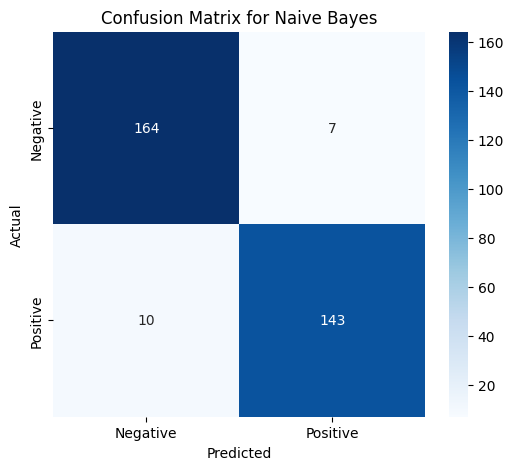

In [11]:
cm_nb = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Naive Bayes")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Random Forest Model with GridSearchCV

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the base model
rf = RandomForestClassifier(random_state=42)

In [13]:
param_grid = {
    'n_estimators': [100, 200],              # number of trees
    'max_depth': [None, 10, 20],             # depth of each tree
    'min_samples_split': [2, 5],             # minimum number of samples required to split
    'min_samples_leaf': [1, 2],              # minimum samples at a leaf node
    'bootstrap': [True, False]               # whether to use bootstrap samples
}

In [14]:
# Choose the feature set
X_for_rf = X_train_tfidf
X_test_rf = X_test_tfidf

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Train the model
grid_search_rf.fit(X_for_rf, y_train)

# Best estimator
best_rf_model = grid_search_rf.best_estimator_
print("Best Parameters:", grid_search_rf.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.0s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.15, fit_prior=True; total time=   0.0s
[CV] END ........................alpha=0.15, fit_prior=False; total time=   0.0s
[CV] END ..........................alpha=0.2, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.2, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.2, fit_prior=False; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END 

In [15]:
y_pred_rf = best_rf_model.predict(X_test_rf)

In [16]:
# Metrics
print("Random Forest Evaluation:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='binary'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf, average='binary'):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf, average='binary'):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Evaluation:
Accuracy:  0.9290
Precision: 0.9221
Recall:    0.9281
F1 Score:  0.9251

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       171
           1       0.92      0.93      0.93       153

    accuracy                           0.93       324
   macro avg       0.93      0.93      0.93       324
weighted avg       0.93      0.93      0.93       324



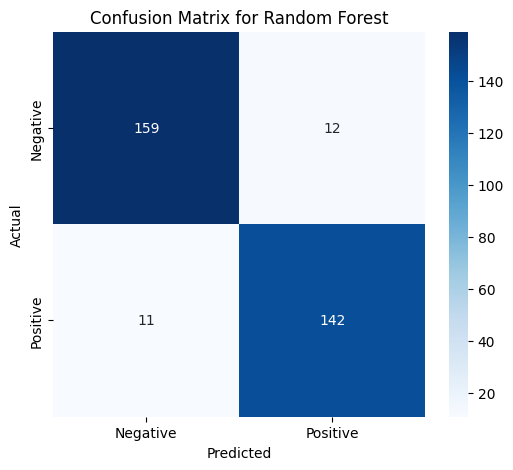

In [17]:
cm_nb = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Random Forest")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Saving the Models

In [18]:
import joblib

# Save models
joblib.dump(best_nb_model, 'naive_bayes_model.pkl')
joblib.dump(best_rf_model, 'random_forest_model.pkl')

# Save vectorizer
joblib.dump(combined_vectorizer, 'combined_tfidf_vectorizer.pkl')

['combined_tfidf_vectorizer.pkl']

# Manual review Prediction

In [19]:
import joblib
import re
# Load models and vectorizer
combined_vectorizer = joblib.load('combined_tfidf_vectorizer.pkl')
naive_bayes_model = joblib.load('naive_bayes_model.pkl')
random_forest_model = joblib.load('random_forest_model.pkl')

# Preprocessing function (you can customize it based on what you did during training)
def preprocess_text(text):
    text = text.lower()
    # Keep English letters and all Bengali characters (Unicode range)
    text = re.sub(r'[^a-zA-Z\u0980-\u09FF]+', ' ', text)
    return text.strip()

# Manual review input
review = "Actually this App is beneficiary for us."
processed_review = preprocess_text(review)
X_input = combined_vectorizer.transform([processed_review])

# Predict with Naive Bayes
nb_pred = naive_bayes_model.predict(X_input)[0]
nb_proba = naive_bayes_model.predict_proba(X_input)[0].max()

# Predict with Random Forest
rf_pred = random_forest_model.predict(X_input)[0]
rf_proba = random_forest_model.predict_proba(X_input)[0].max()

# Output predictions
print(f"Review: {review}")
print(f"Naive Bayes Prediction: {'Positive' if nb_pred else 'Negative'} (Confidence: {nb_proba:.2f})")
print(f"Random Forest Prediction: {'Positive' if rf_pred else 'Negative'} (Confidence: {rf_proba:.2f})")


Review: Actually this App is beneficiary for us.
Naive Bayes Prediction: Positive (Confidence: 0.78)
Random Forest Prediction: Positive (Confidence: 0.62)


In [20]:
import os
os.listdir('/kaggle/working')

['random_forest_model.pkl',
 'naive_bayes_model.pkl',
 '.virtual_documents',
 'combined_tfidf_vectorizer.pkl']

In [21]:
!zip ml_models.zip naive_bayes_model.pkl combined_tfidf_vectorizer.pkl

  adding: naive_bayes_model.pkl (deflated 48%)
  adding: combined_tfidf_vectorizer.pkl (deflated 74%)


In [22]:
import sklearn
import joblib
import sys

print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)
print("python:", sys.version)

scikit-learn: 1.2.2
joblib: 1.5.0
python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
